# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [84]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [4]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/complaints.csv",
    metadata_columns=[
      "Date received", 
      "Product", 
      "Sub-product", 
      "Issue", 
      "Sub-issue", 
      "Consumer complaint narrative", 
      "Company public response", 
      "Company", 
      "State", 
      "ZIP code", 
      "Tags", 
      "Consumer consent provided?", 
      "Submitted via", 
      "Date sent to company", 
      "Company response to consumer", 
      "Timely response?", 
      "Consumer disputed?", 
      "Complaint ID"
    ]
)

loan_complaint_data = loader.load()

for doc in loan_complaint_data:
    doc.page_content = doc.metadata["Consumer complaint narrative"]

Let's look at an example document to see if everything worked as expected!

In [5]:
loan_complaint_data[0]

Document(metadata={'source': './data/complaints.csv', 'row': 0, 'Date received': '03/27/25', 'Product': 'Student loan', 'Sub-product': 'Federal student loan servicing', 'Issue': 'Dealing with your lender or servicer', 'Sub-issue': 'Trouble with how payments are being handled', 'Consumer complaint narrative': "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'Company public response': 'None', 'Company'

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [6]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    loan_complaint_data,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [7]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [8]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [9]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [10]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [11]:
naive_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be mismanagement and errors in the handling of student loans. This includes issues such as incorrect loan balances, misapplied payments, wrongful denials of payment plans, lack of transparency about loan transfers or account status, and disputes over loan information that adversely affect credit reports. Many complaints also mention problems with repayment plans, illegal or unjustified interest capitalization, and inaccurate reporting of loan status—indicating that errors and mismanagement are frequent problems in the student loan experience.'

In [12]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, some complaints did not get handled in a timely manner. For example, the complaint from 03/28/25 filed by MOHELA was marked as "Not timely" in response to the company\'s handling, and the issue regarding delayed responses and unresolved questions persisted over weeks and even months, indicating delays in addressing the complaints.'

In [13]:
naive_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors highlighted in the complaints:\n\n1. **Lack of Clear Communication and Notification:** Many borrowers were not adequately informed about when their repayment was supposed to resume, changes in their loan servicers, or the status of their payments. For example, borrowers reported being unaware of loan transfer statuses, delinquency reports, or overdue payments because they were not properly notified.\n\n2. **Mismanagement and Administrative Errors:** Several complaints pointed to issues such as loans being transferred without proper notification, incorrect or mismatched account information, and failure by servicers to provide detailed breakdowns of interest and principal. This mismanagement caused confusion and unintentional missed payments.\n\n3. **Difficulty in Re-evaluating Payments or Applying Funds:** Some borrowers found it impossible to apply extra payments toward principal or to pay off smaller loan

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data, )

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided context, the most common issue with loans appears to involve problems with how the lender or servicer handles dealing with the borrower. Specific issues include disputes over fees, difficulty with repayment processes (such as applying additional funds to the principal), receiving inaccurate or misleading information about loan balances and terms, and unresolved complaints about loan verification or school legitimacy. \n\nIn summary, the most common issues tend to be related to the lender or servicer's handling of account information, repayment procedures, and transparency, often involving perceived unfair or predatory practices."

In [17]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, all the complaints documented were responded to with a "Closed with explanation" status and were marked as "Timely response?" = "Yes." Therefore, there is no indication that any complaints were left unhandled or did not receive a response in a timely manner.'

In [18]:
bm25_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans for various reasons, including difficulties with payment plans, issues with how payments were handled, and problems with communication. Some specific reasons mentioned in the complaints include:\n\n- Being steered into wrong types of forbearances or having their payment plans mismanaged, leading to increased principal and interest.\n- Loan servicers (such as Aidvantage and Maximus) failing to contact borrowers about account status updates, payment plan changes, or issues like autopay discontinuation.\n- Automatic payments being unenrolled without proper notification, resulting in missed payments and negative credit impacts.\n- Loan transfers between companies occurring without borrowers' awareness, combined with poor communication and email issues (such as emails going to spam), causing borrowers to miss important updates.\n- Borrowers submitting requests for deferment or forbearance not receiving responses, leading to accumulation of bills and fi

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer:

One example could be:

*Retrieve the section on HTTP status code 302 Found from RFC 7231*

On this example the BM25 would be better thanks to strict lexical matching. On this case, this documentation usually have exact numeric or alphanumeric codes (like the status code).


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [85]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [86]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [87]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be problems related to managing and handling the loan information, including errors in loan balances, misapplied payments, wrongful denials of payment plans, and incorrect or incomplete communication from lenders or servicers. Many complaints involve disputes over loan amounts, interest calculations, unauthorized transfers, and mishandling of personal information.'

In [88]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, some complaints did not get handled in a timely manner. For example, the complaint from the first individual regarding the student loan issues has been open since an unspecified date, with ongoing delays—specifically, nearly 18 months without resolution and no response to their requests. This indicates that their complaint has not been addressed promptly.\n\nAdditionally, other complaints mention issues with delays or unresolved problems, but the first case explicitly highlights a significant delay exceeding a year, which suggests that some complaints are not being handled in a timely manner.'

In [89]:
contextual_compression_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for several reasons, including:\n\n1. Lack of awareness and understanding: Borrowers often were not informed about their obligation to repay loans, especially if they were the first in their family to attend college and did not receive clear information from their financial aid officers.\n\n2. Administrative issues and communication problems: Some borrowers experienced poor communication from loan servicers, such as failing to notify them of payment due dates, changes in loan servicers, or the transfer of their loans without proper notification.\n\n3. Difficulty managing payments amidst financial hardships: Borrowers faced challenges in making payments due to stagnant wages, inflation, and the accumulation of interest, which made repayment increasingly difficult over time.\n\n4. Limited options offered by loan servicers: The only options provided—such as forbearance or deferment—often resulted in interest continuing to grow, extending the repaymen

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [25]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issues with loans, based on the complaints provided, include:\n\n- Struggling to repay the loan, often due to high interest, mismanagement, or unfavorable repayment plans.\n- Problems with loan servicing such as misapplied payments, incorrect balances, or errors in account status.\n- Issues with payments not being properly processed or reflected, leading to negative credit reporting.\n- Lack of clear communication, inadequate assistance from loan servicers, or failure to notify borrowers of important changes or delinquency status.\n- Disputes over interest accumulation, loan balance inaccuracies, and improper handling of applications for forgiveness or discharge.\n- Problems related to deceptive practices, including false promises, misrepresented incentives, or illegal handling of loan data.\n\nIn summary, the most common issues tend to revolve around repayment difficulties, billing errors, miscommunication, and improper servicing practices.'

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, some complaints were not handled in a timely manner. Specifically, there are instances where responses from companies, such as Maximus Federal Services, Inc., were delayed or marked as "not timely," including at least one complaint submitted on 03/28/25 that was marked "No" under "Timely response."'

In [28]:
multi_query_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans primarily due to issues such as servicing misconduct, errors in loan balances, misapplied payments, wrongful denials of payment plans, and inadequate communication from loan servicers. Many borrowers were misinformed or not informed about alternative repayment options like income-driven repayment plans or rehabilitation programs, leading to increased interest, ballooning balances, and unmanageable debt. Additionally, coercive practices like forbearance steering—where borrowers are pushed into long-term forbearances without proper guidance—have contributed to difficulties in managing or reducing their debt. Systemic failures such as improper transfer of loans, inaccurate reporting, and breaches of privacy also exacerbated borrowers' inability to successfully repay their loans."

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer:

Generating multiple query reformulations combats:
- Vocabulary mismatch: Different documents often use different wording for the same concept.
- Captures grammatical and structural variants: Queries can be rewritten to include singular/plural forms, verb tenses, or different phrase segmentation.
- Clarifies ambiguous intent. A user’s brief query may be underspecified. Reformulations that add or remove context words (e.g. expanding “python tutorial” into “python programming language tutorial” or “tutorial for snake care”) help retrieve documents across the intended sense space.
- Leverages feedback terms—together: After an initial retrieval pass, terms from the top‐ranked documents can be used to generate new query variants.

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [28]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = loan_complaint_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [29]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [30]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [31]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [32]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [34]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, is problems related to loan servicing and reporting. Specifically, many complaints involve errors in loan balances, misapplied payments, wrongful denials of payment plans, and inaccuracies in credit reporting, such as incorrect information on credit reports and unverified or questionable debt. These issues often stem from systemic problems in how loans are managed, transferred between servicers, or reported to credit bureaus.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, several complaints indicate that they were not handled in a timely manner. Specifically:\n\n- The complaint from row 441 about MOHELA regarding a student loan issue states that the response was "No" for timeliness, and the consumer has not heard from anyone despite multiple calls and efforts, with delays of 15 days for a response and additional wait times of 5-7 business days on multiple occasions.\n- The complaint from row 84 also from MOHELA indicates similar delays, with the consumer waiting on hold for hours and experiencing unacceptable wait times over three months.\n- The complaint from row 418 involving Aidvantage was responded to "Yes" for timeliness, so this one was handled promptly.\n- The complaint from row 474 about Nelnet was responded to "Yes," indicating timely handling.\n\n**In summary:**  \nYes, several complaints—particularly those related to MOHELA—did not get handled in a timely manner, with delays exceeding the standard response time

In [36]:
parent_document_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans primarily due to a combination of factors such as miscommunication, lack of proper notification about payment obligations, financial hardship, and issues related to the management of their loans. For example, some borrowers experienced delays or failures in receiving information about when to start payments or setting up payment plans, which led to delinquency. Others faced severe financial difficulties after graduation, often compounded by insufficient transparency from educational institutions and loan servicers about the long-term consequences of their debt, and in some cases, the schools' own financial instability. Additionally, there were issues with loan servicing practices, such as being reported as delinquent without proper communication or clarity on the reason. Overall, these challenges prevented borrowers from fulfilling their repayment obligations."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [90]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [91]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [92]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be mismanagement and mishandling by servicers, including errors in loan balances, improper classification of loan types, inaccurate or false reporting of delinquency or default, failure to communicate properly with borrowers, and issues related to payment application and interest calculations. Many complaints highlight problems with inaccurate information, lack of transparency, and inadequate customer service, which can lead to financial hardship, damage to credit scores, and increased stress for borrowers.'

In [41]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, yes, several complaints indicate that issues were not handled in a timely manner. For example:\n\n- Multiple complaints from the same individual about delays exceeding the promised response times, such as responses taking longer than 48 hours or several weeks.\n- A complaint (Complaint #12744910) stated that although a promise was made to resolve an issue within 48 hours, ten days passed without resolution.\n- Another complaint (Complaint #12935889) was marked as "No" for timely response, indicating it was not handled promptly.\n- Several complaints mention wait times of hours (sometimes over 3 or 4 hours) or failure to respond within the expected timeframe, including complaints that were "closed with explanation" after delays.\n\nTherefore, the evidence suggests that some complaints did not get handled in a timely manner.'

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans for several reasons based on the complaints in the provided data:\n\n1. **Accumulation of Interest and Unmanageable Debt:** Many borrowers reported that due to interest continually accruing—especially during forbearance or deferment—they owed significantly more than the original loan amount. This made repayment difficult or impossible, as the total debt grew beyond their means.\n\n2. **Limited and Unhelpful Repayment Options:** Borrowers often found the available options—such as forbearance or deferment—to be inadequate, as interest kept piling up. They were sometimes not informed about income-driven repayment plans or loan forgiveness programs that could make payments more manageable.\n\n3. **Mismanagement and Lack of Communication:** Several complaints highlight a failure by servicers to notify borrowers about when repayments would resume, changes in contact information, or the transfer of loans between different servicers without proper notice.

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [35]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [36]:
semantic_documents = semantic_chunker.split_documents(loan_complaint_data[:20])

Let's create a new vector store.

In [37]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Loan_Complaint_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [38]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [39]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [48]:
semantic_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided context, it appears that common issues with loans, particularly student loans, include problems such as:\n\n- Difficulties with repayment processes (e.g., struggling to repay, problems with payment plans)\n- Inaccurate or improper reporting of loan status (e.g., incorrect account status, default notices)\n- Discrepancies or delays in communication about account changes or balances\n- Poor handling of loan documentation and verification\n- Issues arising from loan servicing errors, including incorrect billing, auto-debit problems, or data breaches\n- Allegations of improper or illegal collection and reporting practices\n\nWhile the specific most common issue isn't explicitly stated, the recurring themes point towards problems with loan repayment management, reporting inaccuracies, and poor communication from servicers being frequent issues in loan complaints.\n\nIf you are seeking a concise answer:  \nThe most common issue with loans, based on the complaints provi

In [49]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that several complaints indicate delays or lack of timely handling. Specifically:\n\n1. The complaint about Nelnet (row 17) mentions that despite multiple letters sent via Certified Mail, Nelnet never responded to the complaint or provided answers, indicating a lack of response despite acknowledgment of receipt.\n2. Many complaints, such as those against Maximus Federal Services (row 14), EdFinancial Services (row 4), and Nelnet (rows 16, 17, and 19), state that the companies responded with "Closed with explanation," which often suggests the complaint was addressed post hoc but may not imply a prompt resolution. \n3. The complaint about Nelnet from 05/04/25 (row 17) specifically notes no response to critical correspondence, highlighting a failure to handle the complaint in a timely manner.\n\nTherefore, yes, there are complaints that did not get handled in a timely manner.'

In [50]:
semantic_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'Based on the provided complaints, people failed to pay back their loans for various reasons, including:\n\n1. Lack of communication and transparency from loan servicers, leading to confusion about loan status and payment obligations.\n2. Errors or delays in re-amortizing payments after forbearance ended, causing unexpected increases in payment amounts.\n3. Disputes over loan transfer and missing payments, with some servicers unable to provide records or clarify account details.\n4. Issues with improper reporting or illegal reporting of loans, such as reporting unaff verified debts and collections that may be legally questionable.\n5. Difficulties in providing documentation for loan forgiveness or discharge, often accompanied by stall tactics or deliberate delays by servicers.\n6. Data breaches or mishandling of personal information, which can impact credit and financial stability.\n7. Errors related to account status, such as being reported as delinquent or in default when the borrowe

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer:

Semantic chunking can behave:
- Conversely, if the chunker is tuned for high granularity, it may break each Q&A into tiny, nearly identical fragments, resulting in dozens of nearly duplicate chunks that bloat your index.
- Redundant: Multiple chunks containing the same boilerplate generate near-duplicate vectors. This both increases storage and cost and dilutes retrieval precision, since the model struggles to distinguish the truly relevant bits.
- Lossing question/answer context: A semantic chunker that ignores that structure might split a question and its answer into separate chunks—or mix answers from different questions—leading to fragmented context at retrieval time.

We can adjust it like this:
- Raise the merge threshold so that only very close semantic neighbors get combined or lower the split threshold to avoid breaking question–answer units apart on slight semantic shifts.
- Compute hash-based fingerprints of each chunk’s text and discard exact or near-exact duplicates.
- If the semantic model produces too many tiny fragments, fall back to a fixed-size sliding window.
- Enforce that each chunk contains at least one full question and its complete answer, up to a reasonable character limit.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

#### Setting up env variables

In [42]:
import os
import getpass
from uuid import uuid4
from langchain_core.tracers.context import tracing_v2_enabled
from langsmith import Client

unique_id = uuid4().hex[0:8]
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"AIE7-HW9-{unique_id}"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API Key: ")

tracing_context = tracing_v2_enabled()
tracing_context.__enter__()

client = Client()

#### Generate Synthetic Golden Dataset

In [44]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset import TestsetGenerator
import pandas as pd
from langchain.schema import Document

csv_path = "data/complaints.csv"
df = pd.read_csv(csv_path)

df = df.dropna(subset=["Consumer complaint narrative"])

docs = []
for _, row in df.iterrows():
    content = row["Consumer complaint narrative"]
    metadata = {
        "Complaint ID": str(row["Complaint ID"]),
        "Product": row["Product"],
        "Issue": row["Issue"]
    }
    docs.append(Document(page_content=content, metadata=metadata))

generator_llm = LangchainLLMWrapper(
    ChatOpenAI(model="gpt-4.1",  temperature=0.7)
)
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

dataset = generator.generate_with_langchain_docs(docs[:5], testset_size=10)

df = dataset.to_pandas()
df.head()

Applying SummaryExtractor:   0%|          | 0/3 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/5 [00:00<?, ?it/s]

Node 7c08c997-3fcf-4d31-bcc9-39658d74b872 does not have a summary. Skipping filtering.
Node 8fec82f2-7142-44e3-b383-a70b072e627a does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/13 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,How did Nelnet handle the re-amortization of f...,[The federal student loan COVID-19 forbearance...,"According to the context, after the federal st...",single_hop_specifc_query_synthesizer
1,Why SAVE Plan payment so high when my income l...,[I submitted my annual Income-Driven Repayment...,"Under the SAVE Plan, with income below 150% of...",single_hop_specifc_query_synthesizer
2,Howw does FERPA violashun affect my studnt loa...,[My personal and financial data was compromise...,My personal and financial data was compromised...,single_hop_specifc_query_synthesizer
3,Wher do I find out who my loan servicer is on ...,"[According to Studentaid.gov, Im to get an ema...","Studentaid.gov says that my issuer is nelnet, ...",single_hop_specifc_query_synthesizer
4,Why they say I in forbearance till 2040 but I ...,[Since the resumption of federal loan payments...,They said you was in forbearance until 2040 bu...,single_hop_specifc_query_synthesizer


#### Retriever evaluation

In [66]:
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity
)
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
import time

def evaluate_retriever(name: str, chain, df):
    for test_row in df:
        print(test_row)
        response = chain.invoke({"question": test_row.eval_sample.user_input})
        test_row.eval_sample.response = str(response["response"])
        test_row.eval_sample.retrieved_contexts = [context.metadata["Consumer complaint narrative"] for context in response["context"]]

        time.sleep(12)

    evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

    evaluator_llm = LangchainLLMWrapper(
        ChatOpenAI(model="gpt-4.1-mini", verbose=True)
    )

    result = evaluate(
        experiment_name=name,
        dataset=evaluation_dataset,
        metrics=[
            LLMContextRecall(),
            Faithfulness(),
            FactualCorrectness(),
            ResponseRelevancy(),
            ContextEntityRecall(),
            NoiseSensitivity()
        ],
        llm=evaluator_llm
    )

    print(result)
    return result


##### Evaluate Naive retrieval

In [69]:
retriever_scores = {}
naive_results = evaluate_retriever("Naive Retriever", naive_retrieval_chain, dataset)
retriever_scores["Naive retriever"] = naive_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 1.0000, 'faithfulness': 0.8207, 'factual_correctness(mode=f1)': 0.5164, 'answer_relevancy': 0.8599, 'context_entity_recall': 0.4494, 'noise_sensitivity(mode=relevant)': 0.0000}


##### Evaluate Multi-query Retriever Chain

In [70]:
multi_query_results = evaluate_retriever("Multi-query Retriever", multi_query_retrieval_chain, dataset)
retriever_scores["Multi-query Retriever"] = naive_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'I am filing a complaint regarding improper handling of my federal student loans by Nelnet, particularly related to lack 

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 1.0000, 'faithfulness': 0.9000, 'factual_correctness(mode=f1)': 0.4391, 'answer_relevancy': 0.7837, 'context_entity_recall': 0.4591, 'noise_sensitivity(mode=relevant)': nan}


##### Evaluate Parent Document Retriever Chain

In [75]:
parent_doc_results = evaluate_retriever("Parent Document Retriever", parent_document_retrieval_chain, dataset)
retriever_scores["Parent Document Retriever"] = parent_doc_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'I reached the XXXX payments required for graduate loan forgiveness in XXXX ( or before ). I actually am at XXXX of the X

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.9333, 'faithfulness': 0.7886, 'factual_correctness(mode=f1)': 0.5082, 'answer_relevancy': 0.6881, 'context_entity_recall': 0.4576, 'noise_sensitivity(mode=relevant)': 0.3494}


##### Evaluate Ensemble Retriever Chain

In [93]:
ensemble_results = evaluate_retriever("Ensemble Retriever", ensemble_retrieval_chain, dataset)
retriever_scores["Ensemble"] = ensemble_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'I reached the XXXX payments required for graduate loan forgiveness in XXXX ( or before ). I actually am at XXXX of the X

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[28]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[34]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[52]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[64]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 1.0000, 'faithfulness': 0.8752, 'factual_correctness(mode=f1)': 0.4764, 'answer_relevancy': 0.6980, 'context_entity_recall': 0.4511, 'noise_sensitivity(mode=relevant)': nan}


##### Evaluate Semantic Chunking Retriever Chain

In [76]:
semantic_results = evaluate_retriever("Semantic Chunking Retriever", semantic_retrieval_chain, dataset)
retriever_scores["Semantic Chunking Retriever"] = semantic_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", "To Whom It May Concern, On XX/XX/year>, I experienced a significant and devastating drop in my credit scores : from appr

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.9591, 'faithfulness': 0.8229, 'factual_correctness(mode=f1)': 0.5873, 'answer_relevancy': 0.7010, 'context_entity_recall': 0.5364, 'noise_sensitivity(mode=relevant)': 0.0000}


##### Evaluate BM25 Retriever Chain

In [77]:
bm25_results = evaluate_retriever("BM25 Retriever", bm25_retrieval_chain, dataset)
retriever_scores["BM25"] = bm25_results

eval_sample=SingleTurnSample(user_input='How did Nelnet handle the re-amortization of federal student loan payments after the end of the COVID-19 forbearance program, and what impact did this have on borrowers?', retrieved_contexts=["The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.8273, 'faithfulness': 0.7238, 'factual_correctness(mode=f1)': 0.4873, 'answer_relevancy': 0.6976, 'context_entity_recall': 0.3773, 'noise_sensitivity(mode=relevant)': 0.1044}


#### Compare evaluations

In [101]:
# Naive retrieval
naive = {'context_recall': 1.0000, 'faithfulness': 0.8207, 'factual_correctness(mode=f1)': 0.5164, 'answer_relevancy': 0.8599, 'context_entity_recall': 0.4494, 'noise_sensitivity(mode=relevant)': 0.0000}

# Multi-query
multi = {'context_recall': 1.0000, 'faithfulness': 0.9000, 'factual_correctness(mode=f1)': 0.4391, 'answer_relevancy': 0.7837, 'context_entity_recall': 0.4591, 'noise_sensitivity(mode=relevant)':  0.1220}

# Parent Document
parent = {'context_recall': 0.9333, 'faithfulness': 0.7886, 'factual_correctness(mode=f1)': 0.5082, 'answer_relevancy': 0.6881, 'context_entity_recall': 0.4576, 'noise_sensitivity(mode=relevant)': 0.3494}

# Ensemble
ensemble = {'context_recall': 1.0000, 'faithfulness': 0.8752, 'factual_correctness(mode=f1)': 0.4764, 'answer_relevancy': 0.6980, 'context_entity_recall': 0.4511, 'noise_sensitivity(mode=relevant)': 0.0951}

# Semantic chunking
semantic = {'context_recall': 0.9591, 'faithfulness': 0.8229, 'factual_correctness(mode=f1)': 0.5873, 'answer_relevancy': 0.7010, 'context_entity_recall': 0.5364, 'noise_sensitivity(mode=relevant)': 0.0000}

# BM25
bm = {'context_recall': 0.8273, 'faithfulness': 0.7053, 'factual_correctness(mode=f1)': 0.5100, 'answer_relevancy': 0.6988, 'context_entity_recall': 0.3682, 'noise_sensitivity(mode=relevant)': 0.1392}

As key observations:

- Context Recall: Naive, Multi-query, and Ensemble all hit perfect recall (1.0), so they never miss the gold passage. Semantic chunking is nearly as good (0.9591), while Parent-Doc and BM25 lag behind.
- Faithfulness: Multi-query leads at 0.90, followed by Ensemble (0.8752) and Naive (0.8207). BM25 (0.7053) and Parent-Doc (0.7886) exhibit the lowest faithful grounding.
- Factual Correctness: Semantic chunking tops out at 0.5873—its tighter, semantically coherent chunks help the model answer more accurately. Naive and Parent-Doc hover around 0.51, while Multi-query dips to 0.4391 (despite perfect recall).
- Answer Relevancy: Naive achieves the highest relevancy (0.8599), since it’s pulling the full document and letting the LLM pick. Multi-query, Ensemble, and the more targeted methods fall in the 0.68–0.78 range.
- Entity Recall: Semantic chunking again leads (0.5364), meaning it’s most likely to include the specific entities needed. BM25 is weakest here (0.3682), reflecting its literal term-matching on free-form complaint narratives.
- Noise Sensitivity: Naive and semantic-chunk approaches are perfectly robust (0.0), while Parent-Doc shows some noise leakage (0.3494). The Multi-query and Ensemble metrics show less than the others.

#### Compile evaluations

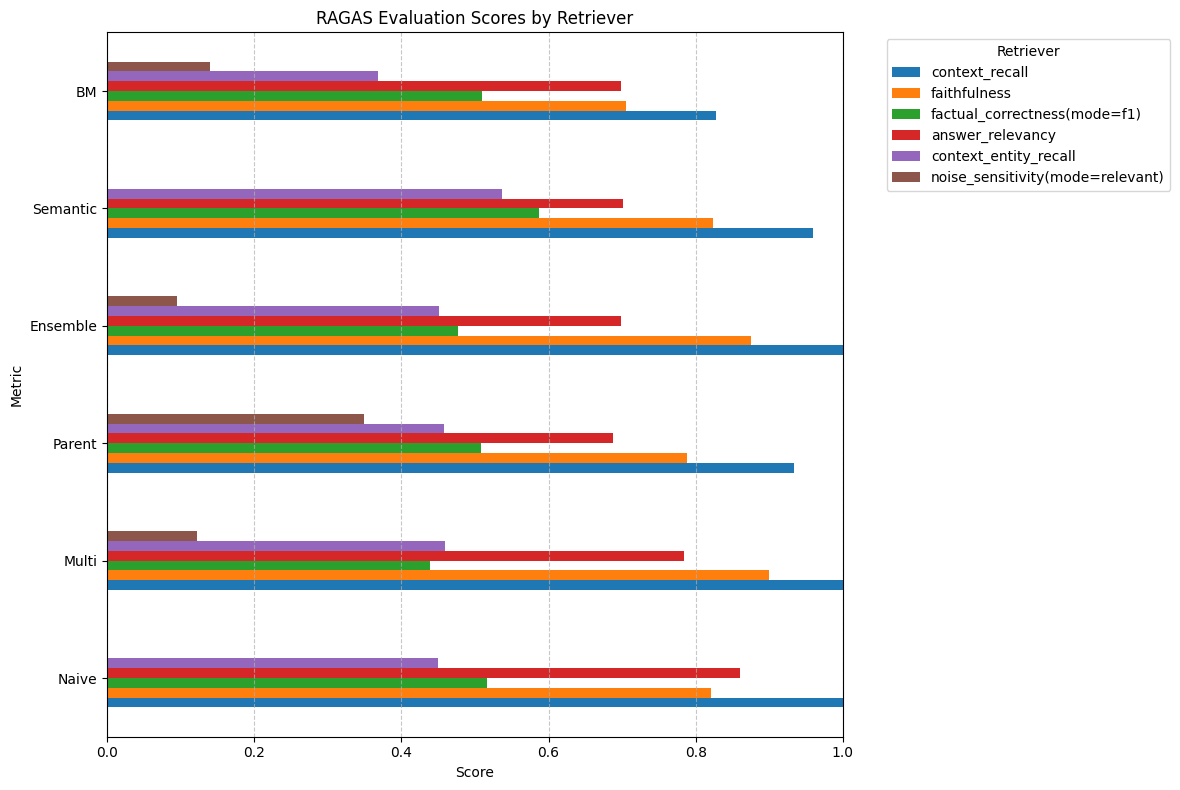

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_scores = pd.DataFrame({
    "Naive": naive,
    "Multi": multi,
    "Parent": parent,
    "Ensemble": ensemble,
    "Semantic": semantic,
    "BM": bm
}).T 

df_plot = df_scores.round(4)

ax = df_plot.plot(kind='barh', figsize=(12, 8))
plt.title("RAGAS Evaluation Scores by Retriever")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Retriever", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()